The goal of this notebook is to apply Principal Component Analysis in order to select important features from our nba dataset

Reading material:

- [pca clearly explained and when to use it](https://towardsdatascience.com/pca-clearly-explained-how-when-why-to-use-it-and-feature-importance-a-guide-in-python-7c274582c37e/?source=friends_link&sk=65bf5440e444c24aff192fedf9f8b64f)
- [step by step manually implementing and explaining](https://sebastianraschka.com/Articles/2014_pca_step_by_step.html)
- [docs page for the pca python package](https://erdogant.github.io/pca/pages/html/index.html)
    - [demo of feature importance](https://erdogant.github.io/pca/pages/html/Examples.html#demonstration-of-feature-importance)

# 1. Importing Packages and Data

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from pca import pca


# Set display options to show all columns and a large width
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)  # Adjust the width as needed

In [5]:
file_id = '1U2UaHWRSkUXfJBn4kBHPYttd3dvw_CZF'
url = f'https://drive.google.com/uc?id={file_id}'
df = pd.read_csv(url, encoding='utf-8')


df.head()

,game_id,season,team_id,team_name,tri_code,team_slug,minutes,field_goals_made,field_goals_attempted,field_goals_percentage,three_pointers_made,three_pointers_attempted,three_pointers_percentage,free_throws_made,free_throws_attempted,free_throws_percentage,rebounds_offensive,rebounds_defensive,rebounds_total,steals,blocks,turnovers,fouls_personal,points,plus_minus_points,estimated_offensive_rating,offensive_rating,estimated_defensive_rating,defensive_rating,estimated_net_rating,net_rating,assist_percentage,assist_to_turnover,assist_ratio,offensive_rebound_percentage,defensive_rebound_percentage,rebound_percentage,estimated_team_turnover_percentage,turnover_ratio,effective_field_goal_percentage,true_shooting_percentage,usage_percentage,estimated_usage_percentage,estimated_pace,pace,pace_per40,possessions,p_i_e,distance,rebound_chances_offensive,rebound_chances_defensive,rebound_chances_total,touches,secondary_assists,free_throw_assists,passes,assists,contested_field_goals_made,contested_field_goals_attempted,contested_field_goal_percentage,uncontested_field_goals_made,uncontested_field_goals_attempted,uncontested_field_goals_percentage,field_goal_percentage,defended_at_rim_field_goals_made,defended_at_rim_field_goals_attempted,defended_at_rim_field_goal_percentage,opponent_points,is_home_team,won_game,is_playoff_game,is_regular_game
0,40400407,2004-05,1610612759,Spurs,SAS,spurs,240:00,29.0,68.0,0.426,7.0,11.0,0.636,16.0,19.0,0.842,8.0,30.0,38.0,4.0,7.0,13.0,20.0,81.0,7.0,99.6,105.2,91.2,94.9,8.4,10.3,0.483,1.08,13.5,0.317,0.696,0.517,15.978,16.9,0.478,0.530,1.0,0.201,81.26,77.5,64.58,77.0,0.542,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.426,0.0,0.0,0.0,74.0,1,1,1,0
1,40400406,2004-05,1610612759,Spurs,SAS,spurs,240:00,31.0,75.0,0.413,8.0,28.0,0.286,16.0,26.0,0.615,13.0,30.0,43.0,3.0,2.0,11.0,18.0,86.0,-9.0,100.7,107.5,119.7,117.3,-19.1,-9.8,0.484,1.25,13.2,0.383,0.696,0.538,14.045,15.0,0.467,0.497,1.0,0.197,82.40,80.5,67.08,80.0,0.408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.413,0.0,0.0,0.0,95.0,1,0,1,0
2,40400405,2004-05,1610612765,Pistons,DET,pistons,265:00,37.0,84.0,0.440,2.0,9.0,0.222,19.0,23.0,0.826,16.0,26.0,42.0,7.0,11.0,11.0,20.0,95.0,-1.0,105.4,108.0,107.6,109.1,-2.2,-1.1,0.459,1.42,13.8,0.438,0.571,0.505,13.316,13.6,0.452,0.505,1.0,0.198,81.22,79.7,66.42,88.0,0.557,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.440,0.0,0.0,0.0,96.0,1,0,1,0
3,40400404,2004-05,1610612765,Pistons,DET,pistons,240:00,41.0,90.0,0.456,2.0,9.0,0.222,18.0,23.0,0.783,13.0,34.0,47.0,13.0,6.0,3.0,22.0,102.0,31.0,111.9,117.2,82.0,80.7,29.9,36.6,0.561,5.75,18.1,0.327,0.714,0.515,4.390,4.6,0.467,0.509,1.0,0.196,88.84,87.5,72.92,87.0,0.736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.456,0.0,0.0,0.0,71.0,1,1,1,0
4,40400403,2004-05,1610612765,Pistons,DET,pistons,240:00,40.0,85.0,0.471,3.0,14.0,0.214,13.0,17.0,0.765,17.0,27.0,44.0,12.0,10.0,11.0,18.0,96.0,17.0,109.7,115.7,94.3,95.2,15.5,20.5,0.550,1.83,17.4,0.429,0.683,0.544,13.717,14.5,0.488,0.519,1.0,0.193,85.64,83.0,69.17,83.0,0.640,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.471,0.0,0.0,0.0,79.0,1,1,1,0


## 1.2 Filtering out df 

So we discovered that many of the columns (like `touches`,`passes`,`assists`, etc) have a 0 for games prior the `2013-14` season. It is likely that those stats were not being tracked then but have elected to do the following (intentionally overwriting `df`):
- keep only regular and playoff games
- keep games from `2013-14` season and onward

In [6]:
shape_before = df.shape

# Making df consist only of regular and playoff games
df_regular_games = df.loc[df['is_regular_game'] == 1]
df_playoff_games = df.loc[df['is_playoff_game'] == 1]
df = pd.concat([df_playoff_games, df_playoff_games], ignore_index=True)

print(f'Shape before: {shape_before}\n Shape after concat regular and playoff: {df.shape}')

Shape before: (55314, 72)
 Shape after concat regular and playoff: (6700, 72)


The following function should add an indicator column for simple subset of games past `2013-14` season

In [10]:
df.head()

,game_id,season,team_id,team_name,tri_code,team_slug,minutes,field_goals_made,field_goals_attempted,field_goals_percentage,three_pointers_made,three_pointers_attempted,three_pointers_percentage,free_throws_made,free_throws_attempted,free_throws_percentage,rebounds_offensive,rebounds_defensive,rebounds_total,steals,blocks,turnovers,fouls_personal,points,plus_minus_points,estimated_offensive_rating,offensive_rating,estimated_defensive_rating,defensive_rating,estimated_net_rating,net_rating,assist_percentage,assist_to_turnover,assist_ratio,offensive_rebound_percentage,defensive_rebound_percentage,rebound_percentage,estimated_team_turnover_percentage,turnover_ratio,effective_field_goal_percentage,true_shooting_percentage,usage_percentage,estimated_usage_percentage,estimated_pace,pace,pace_per40,possessions,p_i_e,distance,rebound_chances_offensive,rebound_chances_defensive,rebound_chances_total,touches,secondary_assists,free_throw_assists,passes,assists,contested_field_goals_made,contested_field_goals_attempted,contested_field_goal_percentage,uncontested_field_goals_made,uncontested_field_goals_attempted,uncontested_field_goals_percentage,field_goal_percentage,defended_at_rim_field_goals_made,defended_at_rim_field_goals_attempted,defended_at_rim_field_goal_percentage,opponent_points,is_home_team,won_game,is_playoff_game,is_regular_game
0,40400407,2004-05,1610612759,Spurs,SAS,spurs,240:00,29.0,68.0,0.426,7.0,11.0,0.636,16.0,19.0,0.842,8.0,30.0,38.0,4.0,7.0,13.0,20.0,81.0,7.0,99.6,105.2,91.2,94.9,8.4,10.3,0.483,1.08,13.5,0.317,0.696,0.517,15.978,16.9,0.478,0.530,1.0,0.201,81.26,77.5,64.58,77.0,0.542,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.426,0.0,0.0,0.0,74.0,1,1,1,0
1,40400406,2004-05,1610612759,Spurs,SAS,spurs,240:00,31.0,75.0,0.413,8.0,28.0,0.286,16.0,26.0,0.615,13.0,30.0,43.0,3.0,2.0,11.0,18.0,86.0,-9.0,100.7,107.5,119.7,117.3,-19.1,-9.8,0.484,1.25,13.2,0.383,0.696,0.538,14.045,15.0,0.467,0.497,1.0,0.197,82.40,80.5,67.08,80.0,0.408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.413,0.0,0.0,0.0,95.0,1,0,1,0
2,40400405,2004-05,1610612765,Pistons,DET,pistons,265:00,37.0,84.0,0.440,2.0,9.0,0.222,19.0,23.0,0.826,16.0,26.0,42.0,7.0,11.0,11.0,20.0,95.0,-1.0,105.4,108.0,107.6,109.1,-2.2,-1.1,0.459,1.42,13.8,0.438,0.571,0.505,13.316,13.6,0.452,0.505,1.0,0.198,81.22,79.7,66.42,88.0,0.557,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.440,0.0,0.0,0.0,96.0,1,0,1,0
3,40400404,2004-05,1610612765,Pistons,DET,pistons,240:00,41.0,90.0,0.456,2.0,9.0,0.222,18.0,23.0,0.783,13.0,34.0,47.0,13.0,6.0,3.0,22.0,102.0,31.0,111.9,117.2,82.0,80.7,29.9,36.6,0.561,5.75,18.1,0.327,0.714,0.515,4.390,4.6,0.467,0.509,1.0,0.196,88.84,87.5,72.92,87.0,0.736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.456,0.0,0.0,0.0,71.0,1,1,1,0
4,40400403,2004-05,1610612765,Pistons,DET,pistons,240:00,40.0,85.0,0.471,3.0,14.0,0.214,13.0,17.0,0.765,17.0,27.0,44.0,12.0,10.0,11.0,18.0,96.0,17.0,109.7,115.7,94.3,95.2,15.5,20.5,0.550,1.83,17.4,0.429,0.683,0.544,13.717,14.5,0.488,0.519,1.0,0.193,85.64,83.0,69.17,83.0,0.640,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.471,0.0,0.0,0.0,79.0,1,1,1,0


In [7]:
def has_acceptable_season(row):
    acceptable_seasons = [
        '2013-14',
        '2014-15',
        '2015-16',
        '2016-17',
        '2017-18',
        '2018-19',
        '2019-20',
        '2020-21',
        '2021-22',
        '2022-23',
        '2023-24'
    ]
    if row['season'] in acceptable_seasons:
        return 1
    else:
        return 0

Using the function and subsetting for when `acceptable_season` == 1 results in the following

In [11]:
shape_before = df.shape

df['acceptable_season'] = df.apply(has_acceptable_season, axis=1)
df = df.loc[df['acceptable_season'] == 1]

print(f'Shape before filtering for acceptable_season: {shape_before}\n Shape after filtering for acceptable_season: {df.shape}')

Shape before filtering for acceptable_season: (6700, 72)
 Shape after filtering for acceptable_season: (3680, 73)


In [12]:
df = df.drop(columns=['acceptable_season'])

# 2. Preprocess data

Before running PCA we need to:
1. Drop obvious non numeric columns
2. Decide which and drop redundant percentage columns
3. Decide which and drop dummy variables
4. Handle missing values
5. Standardize the numeric features (since PCA works best with standardized data)  

**Step 1. Drop the obvious/non numeric columns**
- `game_id`
- `season`
- `team_id`
- `team_name`
- `tri_code`
- `team_slug`
- `minutes`: right now is a string like object





In [22]:
drop_cols1 = [
    'game_id',
    'season',
    'team_id',
    'team_name',
    'tri_code',
    'team_slug',
    'minutes'
]

df = df.drop(columns=drop_cols1)

**Step 2. Decide and drop the redundant percentage columns:**
- `field_goals_percentage`: = `field_goals_made` / `field_goals_attempted`
- `three_pointers_percentage` = `three_pointers_made` / `three_pointers_attempted`
- `free_throws_percentage` = `free_throws_made` / `free_throws_attempted`
- `rebounds_total` = `rebounds_offensive` + `rebounds_defensive`
- `assist_to_turnover` = `assists` / `turnovers`

In [23]:
drop_cols2 = [
    'field_goals_percentage',
    'three_pointers_percentage',
    'free_throws_percentage',
    'rebounds_total',
    'assist_to_turnover'
]

df = df.drop(columns=drop_cols2)

**Step 3. Decide and drop dummy variables**

Going to check the variance of each dummy variable since if the variance is close to 0 it wont really contribute much to PCA and can be dropped

In [21]:
df[['is_home_team', 'won_game', 'is_playoff_game', 'is_regular_game']].var()

is_home_team       0.250068
won_game           0.250068
is_playoff_game    0.000000
is_regular_game    0.000000
dtype: float64

Since .25 is the maximum variance possible for binary dummy variable we'll keep `is_home_team` and `won_game` and drop `is_playoff_game` and `is_regular_game`

In [24]:
drop_cols3 = [
    'is_playoff_game',
    'is_regular_game'
]

df = df.drop(columns=drop_cols3)

At this point `df` should only have numeric colums and will be renamed to `df_num` 

In [25]:
df_num = df
df_num.head()

,field_goals_made,field_goals_attempted,three_pointers_made,three_pointers_attempted,free_throws_made,free_throws_attempted,rebounds_offensive,rebounds_defensive,steals,blocks,turnovers,fouls_personal,points,plus_minus_points,estimated_offensive_rating,offensive_rating,estimated_defensive_rating,defensive_rating,estimated_net_rating,net_rating,assist_percentage,assist_ratio,offensive_rebound_percentage,defensive_rebound_percentage,rebound_percentage,estimated_team_turnover_percentage,turnover_ratio,effective_field_goal_percentage,true_shooting_percentage,usage_percentage,estimated_usage_percentage,estimated_pace,pace,pace_per40,possessions,p_i_e,distance,rebound_chances_offensive,rebound_chances_defensive,rebound_chances_total,touches,secondary_assists,free_throw_assists,passes,assists,contested_field_goals_made,contested_field_goals_attempted,contested_field_goal_percentage,uncontested_field_goals_made,uncontested_field_goals_attempted,uncontested_field_goals_percentage,field_goal_percentage,defended_at_rim_field_goals_made,defended_at_rim_field_goals_attempted,defended_at_rim_field_goal_percentage,opponent_points,is_home_team,won_game
755,37.0,78.0,12.0,26.0,18.0,23.0,6.0,34.0,5.0,4.0,8.0,21.0,104.0,17.0,115.4,116.9,92.7,97.8,22.7,19.1,0.676,20.6,0.178,0.750,0.473,8.877,9.0,0.551,0.590,1.0,0.200,92.00,89.0,74.17,89.0,0.622,17.60,32.0,61.0,90.0,467.0,4.0,1.0,357.0,25.0,18.0,38.0,0.474,19.0,40.0,0.475,0.474,15.0,24.0,0.625,87.0,1,1
756,32.0,71.0,9.0,22.0,13.0,20.0,6.0,21.0,7.0,1.0,13.0,25.0,86.0,-21.0,99.1,101.2,128.9,127.4,-29.8,-26.2,0.406,12.3,0.000,0.000,0.000,14.977,15.3,0.514,0.539,1.0,0.203,84.90,84.5,70.42,85.0,0.297,16.83,21.0,38.0,57.0,377.0,0.0,1.0,274.0,13.0,14.0,30.0,0.467,18.0,41.0,0.439,0.451,16.0,19.0,0.842,107.0,1,0
757,32.0,62.0,10.0,21.0,18.0,24.0,5.0,21.0,8.0,1.0,20.0,26.0,92.0,-19.0,105.1,108.2,128.9,129.1,-23.9,-20.8,0.531,15.5,0.229,0.733,0.462,22.841,23.5,0.597,0.634,1.0,0.199,86.82,85.5,71.25,85.0,0.365,16.36,21.0,40.0,57.0,361.0,2.0,0.0,256.0,17.0,16.0,31.0,0.516,16.0,31.0,0.516,0.516,14.0,20.0,0.700,111.0,1,0
758,36.0,82.0,12.0,26.0,12.0,20.0,11.0,26.0,7.0,1.0,11.0,20.0,96.0,-2.0,105.7,109.1,108.6,110.1,-2.9,-1.0,0.722,20.3,0.260,0.000,0.000,12.115,12.5,0.512,0.529,1.0,0.196,90.52,88.5,73.75,88.0,0.478,16.80,25.0,37.0,60.0,436.0,6.0,1.0,325.0,26.0,17.0,40.0,0.425,19.0,42.0,0.452,0.439,17.0,24.0,0.708,98.0,1,0
759,40.0,68.0,13.0,25.0,17.0,22.0,5.0,34.0,8.0,4.0,22.0,14.0,110.0,15.0,115.0,115.8,101.2,100.0,13.7,15.8,0.750,23.0,0.258,0.814,0.581,24.038,24.2,0.684,0.708,1.0,0.199,94.76,95.0,79.17,95.0,0.626,17.48,17.0,57.0,72.0,441.0,2.0,3.0,333.0,30.0,23.0,32.0,0.719,17.0,36.0,0.472,0.588,12.0,21.0,0.571,95.0,1,1


**Step 4. Handle missing values**

A prior notebook somehwere has the code for why dropping instead of imputing is fine

In [26]:
shape_before = df_num.shape
df_num = df_num.dropna()

print(f'Shape before dropping nas: {shape_before}\n Shape after dropping nas: {df_num.shape}')

Shape before dropping nas: (3680, 58)
 Shape after dropping nas: (3680, 58)


**Step 5. Standardize numeric features**

We will be using `StandardScaler` from scikit learn for this ([docs link](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler))

In [27]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_num)

# convert back to dataframe
df_scaled = pd.DataFrame(df_scaled, columns=df_num.columns)

# 3. Running PCA

## 3.1 Using pca module

Relevant links:
- [from docs: demonstration of feature importance](https://erdogant.github.io/pca/pages/html/Examples.html#demonstration-of-feature-importance)
- [from docs: example of best performing features](https://erdogant.github.io/pca/pages/html/Algorithm.html#best-performing-features)

In [28]:
# initialize to reduce data up to num components that explains 95% of variance
model = pca(n_components=0.95)

# fit transform
output = model.fit_transform(df_scaled)

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [58] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [22] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [58] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[22]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


The following prints out the top features

In [44]:
output['topfeat'].head(60)

,PC,feature,loading,type
0,PC1,estimated_offensive_rating,2.506311e-01,best
1,PC2,opponent_points,3.544161e-01,best
2,PC3,possessions,3.447574e-01,best
3,PC4,estimated_team_turnover_percentage,3.929461e-01,best
4,PC5,contested_field_goals_made,3.257202e-01,best
5,PC6,passes,4.008676e-01,best
6,PC7,offensive_rebound_percentage,3.225980e-01,best
7,PC8,free_throws_made,3.409418e-01,best
8,PC9,defensive_rebound_percentage,4.248352e-01,best
9,PC10,steals,4.622097e-01,best


In [55]:
output['topfeat']['feature'].to_list()

['estimated_offensive_rating',
 'opponent_points',
 'possessions',
 'estimated_team_turnover_percentage',
 'contested_field_goals_made',
 'passes',
 'offensive_rebound_percentage',
 'free_throws_made',
 'defensive_rebound_percentage',
 'steals',
 'defended_at_rim_field_goals_made',
 'contested_field_goal_percentage',
 'defensive_rebound_percentage',
 'free_throw_assists',
 'is_home_team',
 'estimated_usage_percentage',
 'free_throw_assists',
 'is_home_team',
 'secondary_assists',
 'fouls_personal',
 'blocks',
 'blocks',
 'field_goals_made',
 'field_goals_attempted',
 'three_pointers_made',
 'three_pointers_attempted',
 'free_throws_attempted',
 'rebounds_offensive',
 'rebounds_defensive',
 'turnovers',
 'points',
 'plus_minus_points',
 'offensive_rating',
 'estimated_defensive_rating',
 'defensive_rating',
 'estimated_net_rating',
 'net_rating',
 'assist_percentage',
 'assist_ratio',
 'rebound_percentage',
 'turnover_ratio',
 'effective_field_goal_percentage',
 'true_shooting_percentag

Explained variance plot

(<Figure size 1500x1000 with 1 Axes>,
 <Axes: title={'center': 'Cumulative explained variance\n 22 Principal Components explain [96.65%] of the variance.'}, xlabel='Principal Component', ylabel='Percentage explained variance'>)

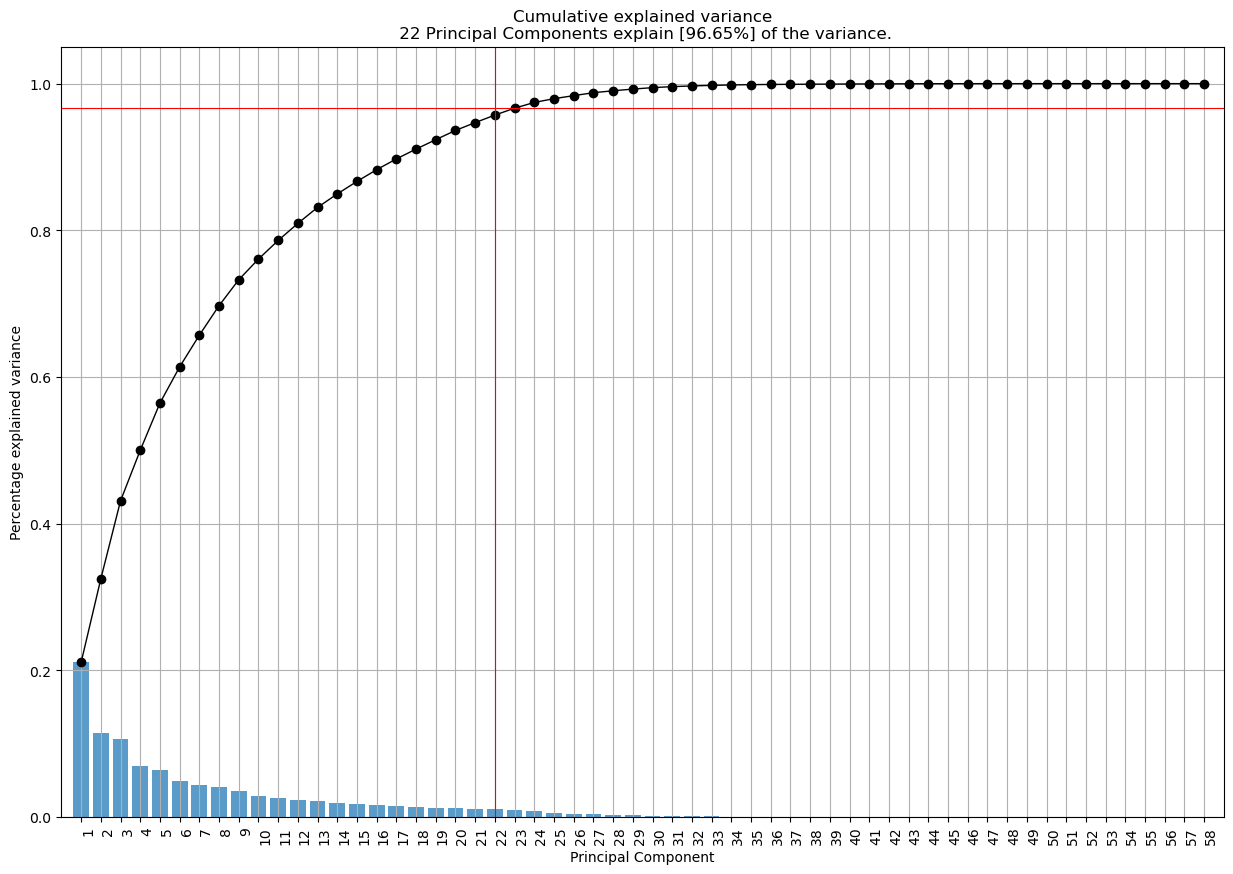

In [45]:
model.plot()

What happens if I drop the dummy var columns

In [46]:
df_scaled2 = df_scaled.drop(columns=['is_home_team', 'won_game'])

In [47]:
# initialize to reduce data up to num components that explains 95% of variance
model2 = pca(n_components=0.95)

# fit transform
output2 = model2.fit_transform(df_scaled2)

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [56] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [20] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [56] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[20]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


(<Figure size 1500x1000 with 1 Axes>,
 <Axes: title={'center': 'Cumulative explained variance\n 20 Principal Components explain [96.08%] of the variance.'}, xlabel='Principal Component', ylabel='Percentage explained variance'>)

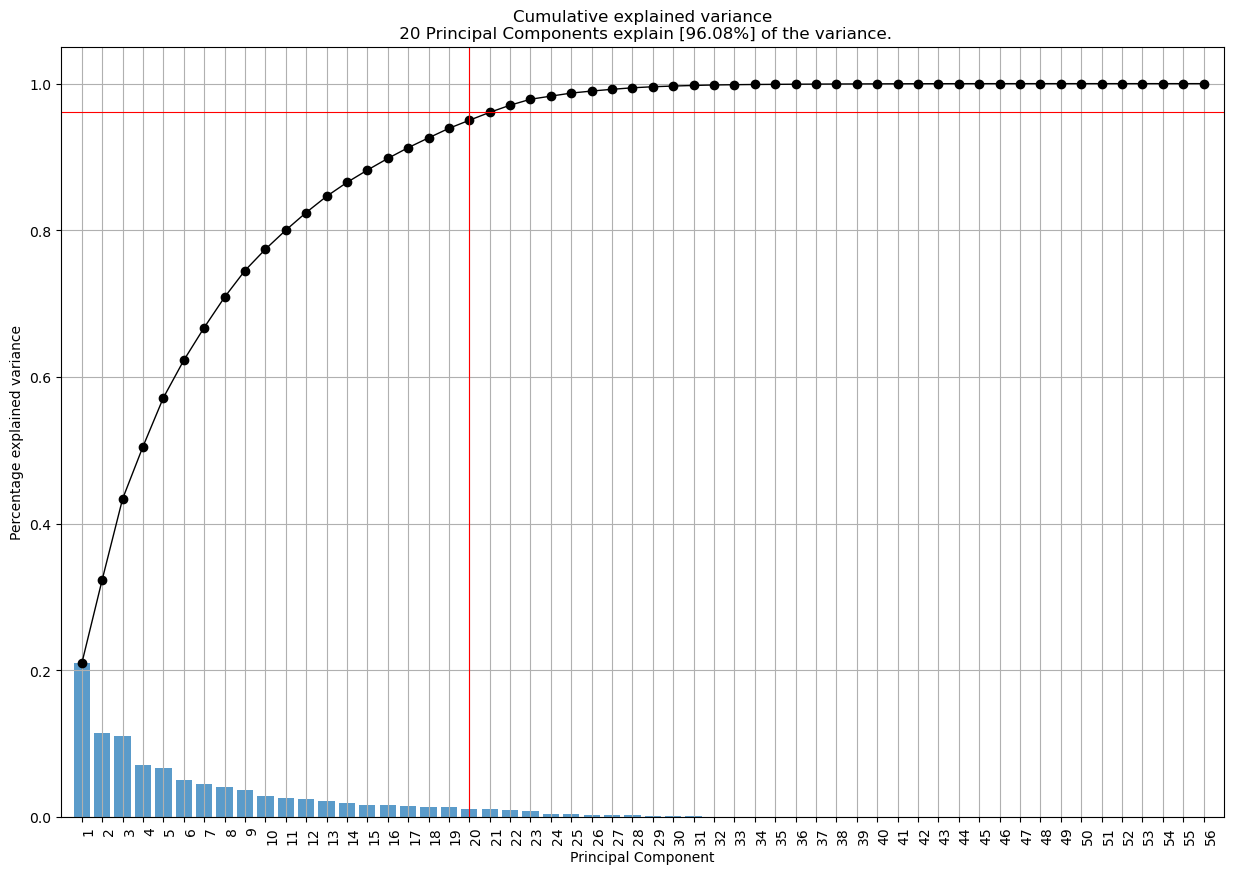

In [48]:
model2.plot()

## 3.2 Manually